In [1]:
from matplotlib.patches import Patch
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import scipy.io
import os

In [2]:
def gen_logbf_barplot(bf, model_names, outpath=None, cmap_name='bone'):
    """Create barplots for subjectwise model comparison using log-scale.

    Args:
        bf: 
            bayes factor vector of size n_subjects
        modelname: 
            two-element list of modelnames
        outpath (optional):
            path specification for saving figure
        cmap_name: 
            name of matplotlib colormap used to discriminate evidence levels 
    """
    logbf = np.log10(bf)
    
    fig, ax = plt.subplots(nrows=1, ncols=1, facecolor='w', figsize=(20, 5))
    
    b = ax.bar(range(n_subjects), logbf)

    cmap = cm.get_cmap(cmap_name)
    color = {
        'extreme': cmap(0),
        'vstrong': cmap(1/5),
        'strong': cmap(2/5),  
        'moderate': cmap(3/5),
        'anecdotal': cmap(4/5),
    }
    
    for rect in b:
        if np.abs(rect.get_height()) < np.log10(3):
            rect.set_color(color['anecdotal'])
        elif np.abs(rect.get_height()) < np.log10(10):
            rect.set_color(color['moderate'])
        elif np.abs(rect.get_height()) < np.log10(30):
            rect.set_color(color['strong'])
        elif np.abs(rect.get_height()) < np.log10(100):
            rect.set_color(color['vstrong'])
        else:
            rect.set_color(color['extreme'])
        
    ax.set_title('Individual Bayes Factors')
    ax.set_xlim((-1, n_subjects))
    ax.set_xlabel('Subjects')
    ax.set_xticks(range(n_subjects))
    ax.set_xticklabels([f'm{sub:02}' for sub in range(2, n_subjects+2)],
                      rotation=-45)
    ax.set_ylim((-3, 3))
    ax.set_ylabel(r'$\log_{10}(BF)$', rotation=90)
    ax.set_axisbelow(True)
    ax.grid()

    legend_elements = [Patch(facecolor=col, edgecolor='k', label=key) 
                   for key, col in color.items()]
    ax.legend(handles=legend_elements, bbox_to_anchor=(1, .7))
    ax.annotate(r'$\uparrow$' + model_names[0], 
                [1.01, .8], xycoords='axes fraction', fontsize=20)
    ax.annotate(r'$\downarrow$' + model_names[1], 
                [1.01, .1], xycoords='axes fraction', fontsize=20)
    plt.tight_layout()
    
    if outpath:
        fig.savefig(outpath)
        
def gen_pep_barplot(pep, model_names, outpath=None):
    """Create protected exceedance probability barplot.

    Args:
        pep: 
            protected exceedance probabilities for any number of models
        modelname: 
            list of modelnames
        outpath (optional):
            path specification for saving figure
    """
    n_models = len(pep)

    fig, ax = plt.subplots(ncols=1, nrows=1, facecolor='w', figsize=(1+n_models, 5))

    ax.bar(range(n_models), pep, width=.65, color='gray')
    ax.plot([-.5, n_models-.5], np.ones(2)*.95, color='r')

    for i, val in enumerate(pep):
        ax.text(i - .15, val + .02, f'{val:.3f}', 
                color='k')

    ax.set_xlim([-.5, n_models-.5])
    ax.set_xticks(range(n_models))
    ax.set_xticklabels(model_names)
    ax.set_ylim([0, 1])
    ax.set_title('Protected exceedance probability', pad=25)
    ax.set_axisbelow(True)
    ax.grid()

    if outpath:
        plt.savefig(outpath)
        
def gen_pmp_implot(pmp, modelnames, outpath=None, cmap='bone_r') -> None:
    """Create imagesc / imshow plot for posterior model probabilities.
    
    Args:
        pmp: np.ndarray (n_models x n_subjects)
            posterior model probabilities for arbitrary number of models
        modelnames: list 
        outpath (optional): str
            path specification for saving figure
        cmap_name (optional): str
    """
    pmp_norm = np.divide(pmp, np.mean(np.sum(pmp, 0)))
    n_models = pmp_norm.shape[0]
    n_subjects = pmp_norm.shape[1]

    fig, ax = plt.subplots(nrows=1, ncols=1, facecolor='w', 
                           figsize=(20, n_models+1))

    im = ax.imshow(
        pmp_norm, 
        aspect='auto',
        cmap=cmap,
        origin='upper'
    )
    im.set_clim(0, 1)

    ax.set_title('Posterior model probability')

    ax.set_xticks(np.arange(0, n_subjects, 1))
    ax.set_xticks(np.arange(-.5, n_subjects, 1), minor=True)
    ax.set_xticklabels([f'm{sub:02}' for sub in range(2, n_subjects+2)],
                       rotation=-45)
    ax.set_xlabel('Subjects')
    ax.set_yticks(np.arange(0, n_models, 1))
    ax.set_yticks(np.arange(-.5, n_models, 1), minor=True)
    ax.set_ylim([n_models-.5, -.5])
    ax.set_yticklabels(modelnames)
    ax.set_ylabel('Model')
    ax.grid(which='minor', color='k')

    cbar = fig.colorbar(im, ax=ax, pad=0.01)
    plt.tight_layout()
        
    if outpath:
        fig.savefig(outpath)

# Model selection
In this sections HLM model output is used for Bayesian model comparison. 
## Factorial Model
### Prediction-error independent (PI) vs prediction-error dependent (PD)
First, model indicator variable $z_i$ is used to discriminate between prediction-error independent (PI) and prediction-error dependent (PD) models. This approach called transdimensional MCMC encompasses both reversible jump MCMC and the product space technique (Sission, 2005). Bayes factors for PI vs PD model selection can be directly calculated for each participant as a ratio of model indicator samples. Bayes factor is the standard Bayesian solution to the model selection problems (Lewis & Raftery, 1997). Bayes factor (BF) for two models $M_1$ and $M_2$ is defined as:
$$BF_{12}=\frac{p(D|M_1)}{p(D|M_2)}$$

In [3]:
path_jags_output = 'data/jags_output/'

path_full = os.path.join(path_jags_output, 'pc_factorial_run1.mat')             # full HLM model
path_null = os.path.join(path_jags_output, 'pc_factorial_run1_null.mat')        # HLM disconnected from data 
path_pi = os.path.join(path_jags_output, 'pc_factorial_run1_pi_only.mat')       # pz probing only PI model (z=1)
path_pd = os.path.join(path_jags_output, 'pc_factorial_run1_pd_only.mat')       # pz probing only PD model (z=2)

n_subjects = 32
sublabels = [f'm{sub:02}' for sub in range(2, n_subjects+2)]

In [4]:
mat = scipy.io.loadmat(path_full, variable_names=['samples'], squeeze_me=True)
z = mat['samples']['z'].item()

In [5]:
# Calculate BF as a ratio of model indicator samples
eps = np.finfo(float).eps 

pmp = np.empty((2, n_subjects), dtype=float)
pmp[0] = np.sum(z == 1, (0, 1)) # PI model 
pmp[1] = np.sum(z == 2, (0, 1)) # PD model
pmp[pmp == 0] = eps # avoid zero-division

bf_main = np.divide(pmp[0], pmp[1])

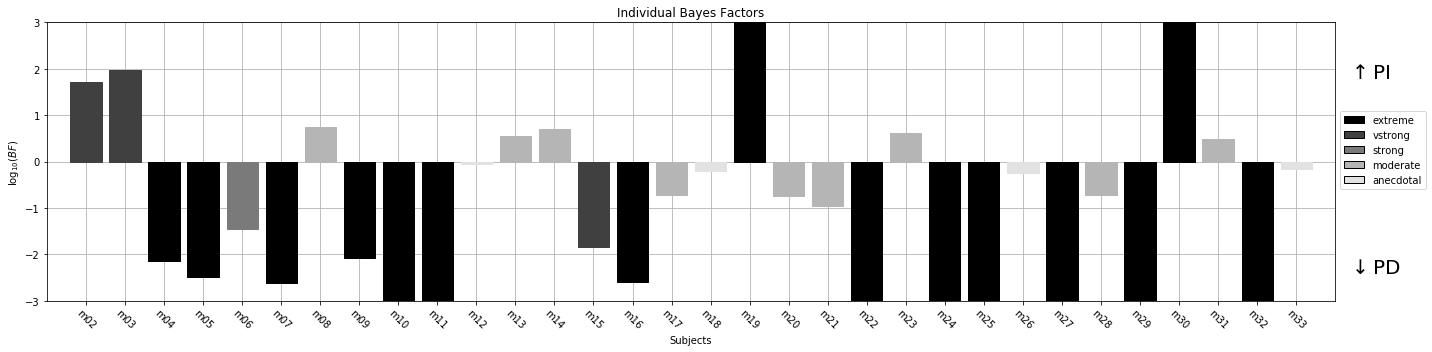

In [6]:
gen_logbf_barplot(bf_main, ['PI', 'PD'], 
                  outpath='pygures/logbf_pi_vs_pd.png', cmap_name='Greys_r')

### Condition independent (CI) vs condition dependent (CD)
Secondly, to select between CI and CD models, full HLM is reduced to simpler hierarchical model by setting infinite precision for indicator variable $z_i$. This is done twice to obtain separate posterior distributions for PI and PD models. Then, prior and posterior distributions for the node capturing the difference between learning rates for reward and punishment conidtions $\xi \alpha$ are extracted. Prior distribution for $\xi \alpha$ can be easily estimated by running full HLM model disconnected from the data. Finally, prior and posterior point density estimate for $\xi \alpha = 0$ is used as an input to the Savage-Dickey method. Since CI and CD models can be considered as nested models, i.e. by setting $\xi \alpha = 0$ we reduce CD model to CI model, we can calculate Bayes factors
$$BF_{CI, CD}=\frac{p(\xi\alpha=0|D,H_1)}{p(\xi\alpha=0|H_1)},$$
where $H_1$ is the alternative hypothesis that $H_1: \xi\alpha\neq 0$.

### CI vs CD for prediction-error independent model

In [7]:
# PI only
mat = scipy.io.loadmat(path_null, variable_names=['samples'], squeeze_me=True)
xi_null = mat['samples']['xi_alpha_pi'].item()
mat = scipy.io.loadmat(path_pi, variable_names=['samples'], squeeze_me=True)
xi_alpha_pi = mat['samples']['xi_alpha_pi'].item()

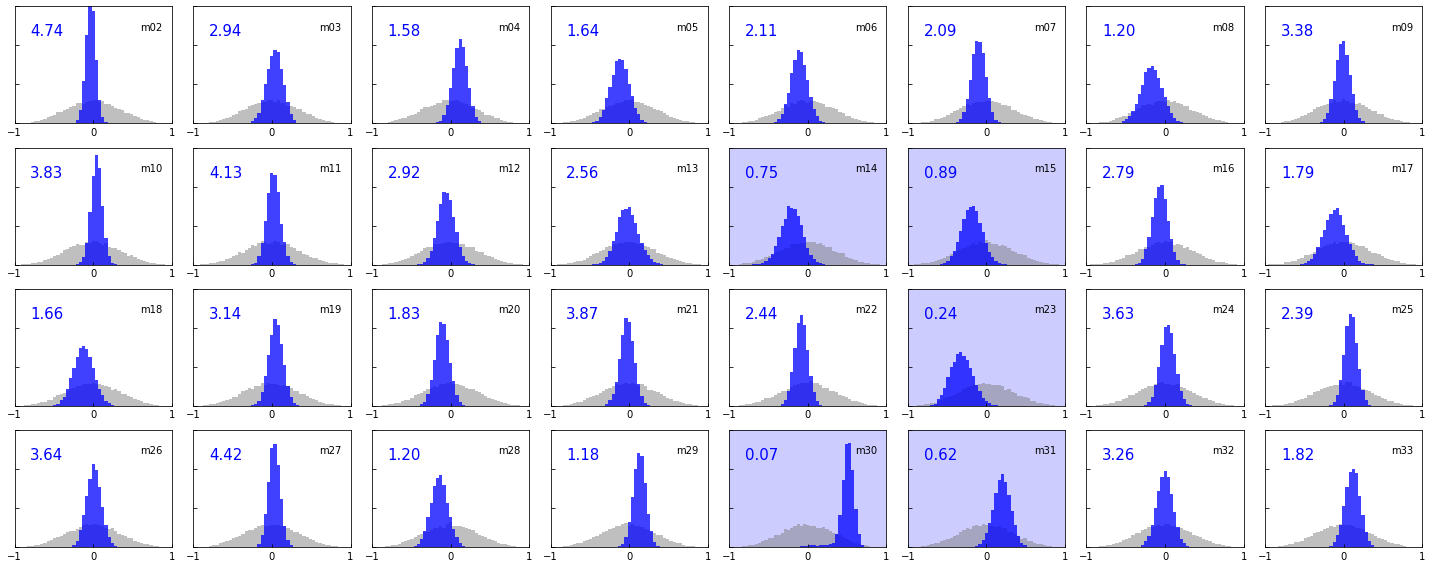

In [8]:
fig, ax = plt.subplots(nrows=4, ncols=8, facecolor='w', figsize=(20, 8))

pmp_single = np.empty((2, n_subjects), dtype=float)
bins = np.linspace(-1, 1, 50)
mid = int((len(bins) - 2) / 2) # Middle index for histogram

for sub in range(n_subjects):
    
    i, j = sub // 8, sub % 8
    
    hprior = ax[i,j].hist(xi_null[:, :, sub].flatten(), bins,
                 density=True, color='grey', alpha=.5, stacked=True)
    hpostr = ax[i,j].hist(xi_alpha_pi[:, :, sub].flatten(), bins,
                 density=True, color='blue', alpha=.75, stacked=True)

    ax[i,j].set_xlim([-1, 1])
    ax[i,j].set_xticks([-1, 0, 1])
    ax[i,j].set_ylim([0, 6])
    ax[i,j].set_yticklabels([])
    ax[i,j].tick_params(direction='in')

    # Get density for xi=0 (null model)
    pmp_single[0, sub] = hprior[0][mid]  # CI (null model)
    pmp_single[1, sub] = hpostr[0][mid]  # CD model

pmp_single[pmp_single == 0] = eps
bf_single = np.divide(pmp_single[1], pmp_single[0])

for sub, axes in enumerate(ax.flatten()):
    
    axes.annotate(f'{bf_single[sub]:0.2f}', xy=(0.1, .75), 
                  xycoords='axes fraction', size=15, color='blue')
    axes.annotate(sublabels[sub], xy=(.8, .8),
                  xycoords='axes fraction', size=10)
    if bf_single[sub] < 1:
        axes.set_facecolor([0, 0, 1, 0.2]) # transparent blue

plt.tight_layout()
fig.savefig('pygures/posterior_xi_single.png')

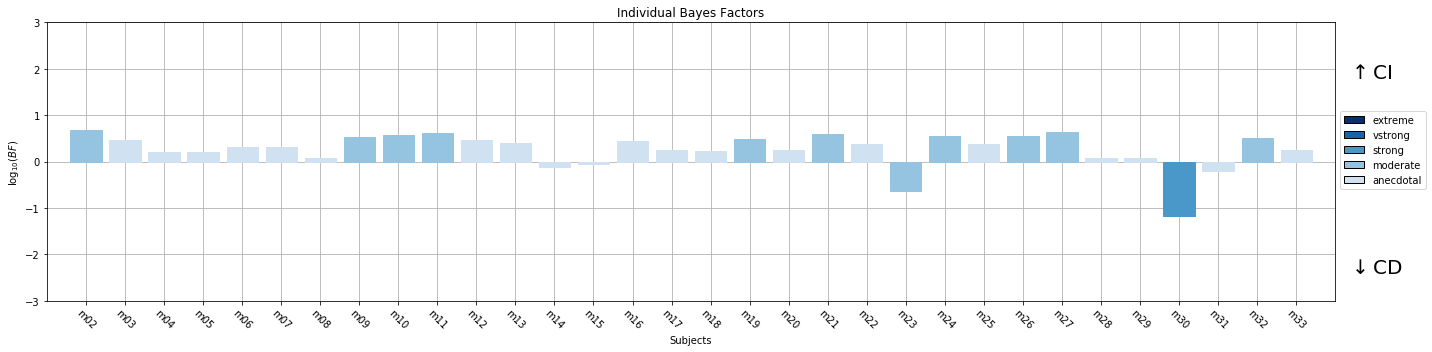

In [9]:
gen_logbf_barplot(bf_single, ['CI', 'CD'], outpath='pygures/logbf_ci_vs_cd_single.png', cmap_name='Blues_r')

### CI vs CD for prediction-error dependent model

In [10]:
# PD only
mat = scipy.io.loadmat(path_null, variable_names=['samples'], squeeze_me=True)
xi_null = mat['samples']['xi_alpha_pd'].item()
mat = scipy.io.loadmat(path_pd, variable_names=['samples'], squeeze_me=True)
xi_alpha_pd = mat['samples']['xi_alpha_pd'].item()

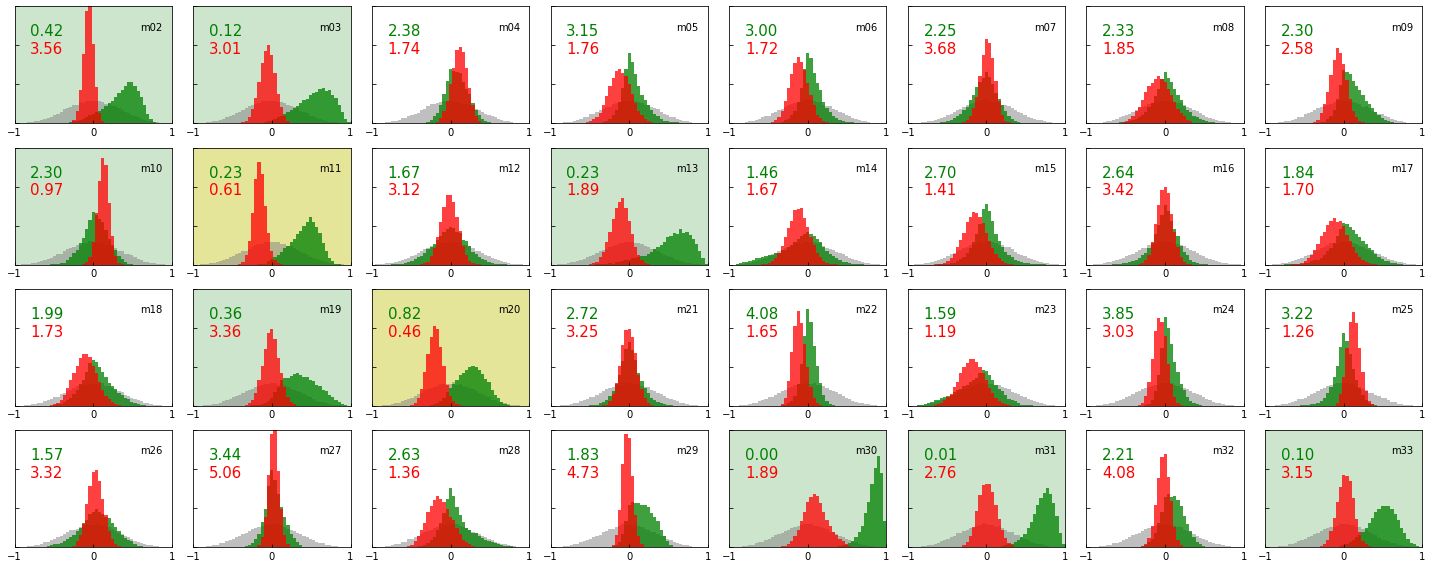

In [11]:
fig, ax = plt.subplots(nrows=4, ncols=8, facecolor='w', figsize=(20, 8))

pmp_plus = np.empty((2, n_subjects), dtype=float)
pmp_minu = np.empty((2, n_subjects), dtype=float)

bins = np.linspace(-1, 1, 50)
mid = int((len(bins) - 2) / 2) # Middle index for histogram

for sub in range(n_subjects):
    
    i, j = sub // 8, sub % 8
    
    hprior = ax[i,j].hist(xi_null[:, :, sub, :].flatten(), bins,
                          density=True, color='grey', alpha=.5, stacked=True)
    hpostr_plus = ax[i,j].hist(xi_alpha_pd[:, :, sub, 0].flatten(), bins,
                               density=True, color='green', 
                               alpha=.75, stacked=True)
    hpostr_minu = ax[i,j].hist(xi_alpha_pd[:, :, sub, 1].flatten(), bins,
                               density=True, color='red', 
                               alpha=.75, stacked=True)

    ax[i,j].set_xlim([-1, 1])
    ax[i,j].set_xticks([-1, 0, 1])
    ax[i,j].set_ylim([0, 6])
    ax[i,j].set_yticklabels([])
    ax[i,j].tick_params(direction='in')

    # Get density for xi=0 (null model)
    pmp_plus[0, sub] = hprior[0][mid]  # CI (null model)
    pmp_minu[0, sub] = hprior[0][mid]  
    pmp_plus[1, sub] = hpostr_plus[0][mid]  
    pmp_minu[1, sub] = hpostr_minu[0][mid]  

pmp_plus[pmp_plus == 0] = eps
pmp_minu[pmp_minu == 0] = eps
bf_plus = np.divide(pmp_plus[1], pmp_plus[0])
bf_minu = np.divide(pmp_minu[1], pmp_minu[0])

for sub, axes in enumerate(ax.flatten()):
    
    axes.annotate(f'{bf_plus[sub]:0.2f}', xy=(0.1, .75), 
                  xycoords='axes fraction', size=15, color='green')
    axes.annotate(f'{bf_minu[sub]:0.2f}', xy=(0.1, .6), 
                  xycoords='axes fraction', size=15, color='red')
    axes.annotate(sublabels[sub], xy=(.8, .8),
                  xycoords='axes fraction', size=10)
    if bf_plus[sub] < 1:
        axes.set_facecolor([0, .5, 0, 0.2]) # transparent green
    if bf_minu[sub] < 1:
        axes.set_facecolor([0, .5, 0, 0.2]) # transparent red
    if bf_plus[sub] < 1 and bf_minu[sub] < 1:
        axes.set_facecolor([.75, .75, 0, 0.4]) # transparent yellow

plt.tight_layout()
fig.savefig('pygures/posterior_xi_dual.png')

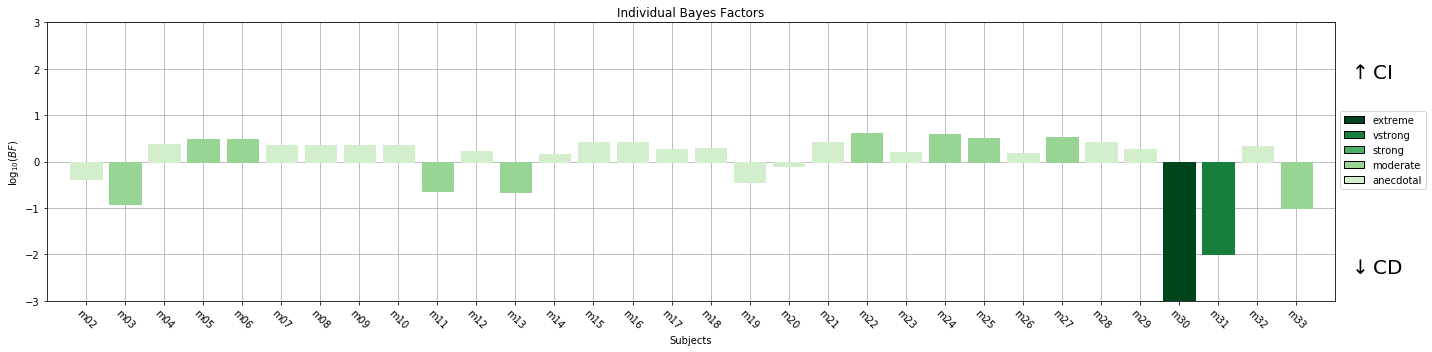

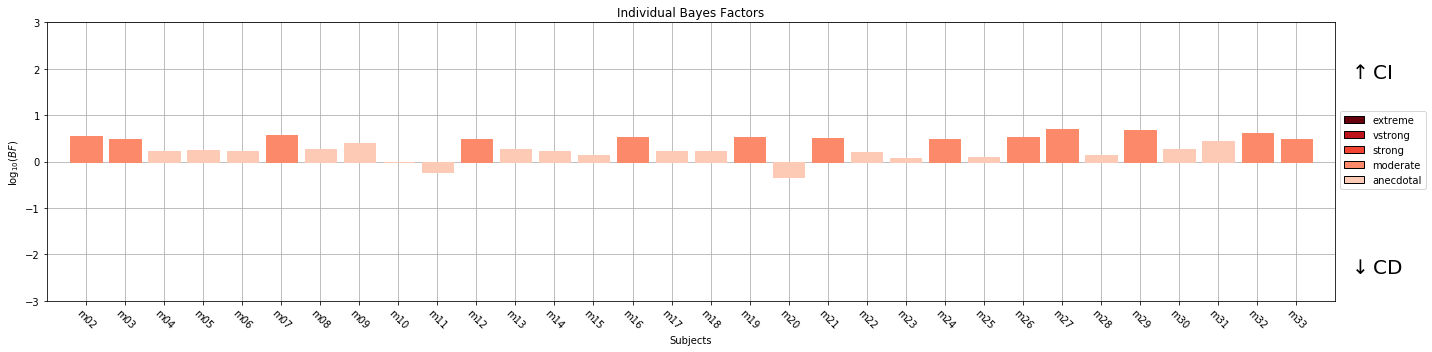

In [12]:
gen_logbf_barplot(bf_plus, ['CI', 'CD'], outpath='pygures/logbf_ci_vs_cd_plus.png', cmap_name='Greens_r')
gen_logbf_barplot(bf_minu, ['CI', 'CD'], outpath='pygures/logbf_ci_vs_cd_minu.png', cmap_name='Reds_r')

In [13]:
# save posterior model probabilities to *.mat format
mdict = {
    'pmp_main': pmp,
    'pmp_single': pmp_single,
    'pmp_plus': pmp_plus,
    'pmp_minu': pmp_minu
}

# scipy.io.savemat('data/pmp_factorial.mat', mdict, appendmat=True)

Before running code below run `dn_bm_03_vba.m` script to obtain posterior exceedance probabilities

In [14]:
mat = scipy.io.loadmat('data/vba_input/pep_factorial.mat', squeeze_me=True)
pep_main = mat['pep_main']
pep_single = mat['pep_single']
pep_plus = mat['pep_plus']
pep_minu = mat['pep_minu']

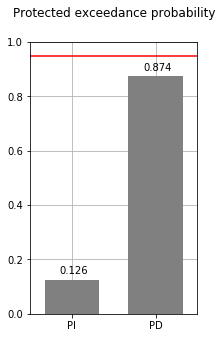

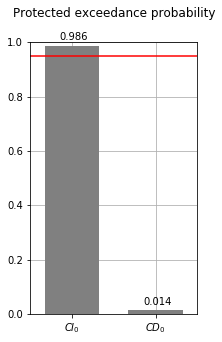

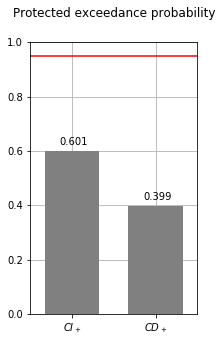

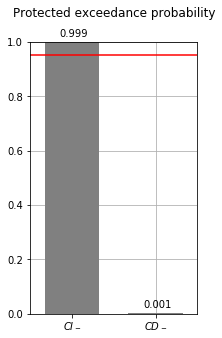

In [15]:
gen_pep_barplot(pep_main, ['PI', 'PD'], 
                outpath='pygures/pep_pi_vs_pd.png')
gen_pep_barplot(np.flip(pep_single), ['$CI_0$', '$CD_0$'], 
                outpath='pygures/pep_ci_vs_cd_zero.png')
gen_pep_barplot(np.flip(pep_plus), ['$CI_+$', '$CD_+$'], 
                outpath='pygures/pep_ci_vs_cd_plus.png')
gen_pep_barplot(np.flip(pep_minu), ['$CI_-$', '$CD_-$'], 
                outpath='pygures/pep_ci_vs_cd_minus.png')

# Sequential HLM

In [5]:
path_seq = os.path.join(path_jags_output, 'pc_seq_trick_run1.mat')       

sublabels = [f'm{sub:02}' for sub in range(2, n_subjects+2)]
modelnames = ['PICI', 'PICD', 'PDCI', 'PDCD']

mat = scipy.io.loadmat(path_seq, variable_names=['samples'], squeeze_me=True)
z = mat['samples']['z'].item()

In [6]:
# Calculate posterior model probabilities
eps = np.finfo(float).eps 
pmp_seq = np.concatenate(
    tuple(np.sum((z == i) + (z == i+4), axis=(0, 1))[np.newaxis, :] 
          for i in range(1, 5)), 
    axis=0
)
pmp_seq = pmp_seq.astype(float)
pmp_seq[pmp_seq == 0] = eps

# Save posterior model probabilities to *.mat format
# scipy.io.savemat('data/pmp_seq.mat', {'pmp_seq': pmp_seq}, appendmat=True)

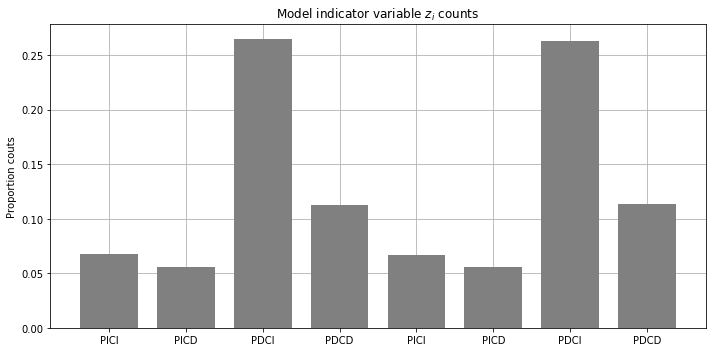

In [11]:
# Show all subjects counts of z
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
ax.hist(
    z.flatten(), 
    np.arange(9) + .5,
    rwidth=.75, 
    density=True,
    color='gray'
)
ax.set_xticks(np.arange(1, 9))
ax.set_xticklabels(2*modelnames)
ax.set_ylabel('Proportion couts')
ax.set_title('Model indicator variable $z_i$ counts')
ax.set_axisbelow(True)
ax.grid()

plt.tight_layout()
fig.savefig('figures-poster/z_posterior.svg')

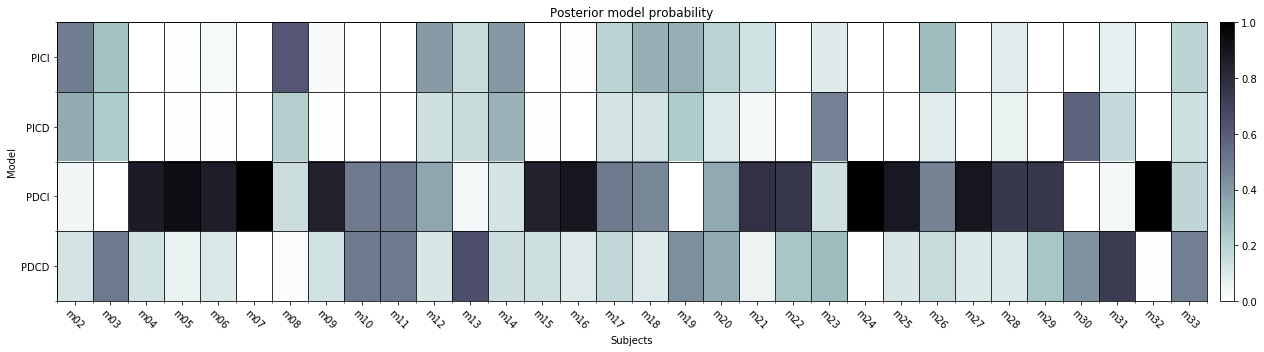

In [10]:
gen_pmp_implot(pmp_seq, modelnames, outpath='pygures/pmp_seq.png')

# plt.tight_layout()
# plt.savefig('figures-poster/z_posterior_subject.svg')

Before running code below run `dn_bm_03_vba.m` script to obtain posterior exceedance probabilities

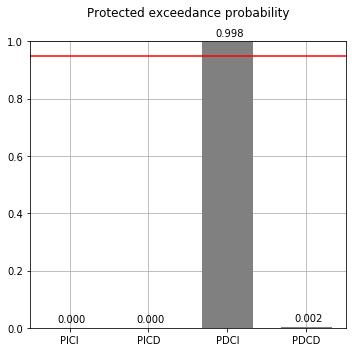

In [9]:
mat = scipy.io.loadmat('data/vba_input/pep_seq.mat', squeeze_me=True)
pep_seq = mat['pep_seq']

gen_pep_barplot(pep_seq, modelnames, 
                outpath='pygures/pep_seq.png')

# plt.tight_layout()
# plt.savefig('figures-poster/pep.svg')